# Questão 2

In [589]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [590]:
# Importar a base de dados
originaldata = pd.read_excel('Bases_Final_ADS_Jun2021.xlsx', sheet_name=1)

# Reordering columns, it will be usefull for correlation heatmap
originaldata = originaldata[['data_tidy',
                             'com_co', 'com_n', 'com_ne', 'com_s', 'com_se',
                             'ind_co', 'ind_n', 'ind_ne', 'ind_s', 'ind_se',
                             'res_co', 'res_n', 'res_ne', 'res_s', 'res_se',
                             'renda_r', 'pop_ocup_br', 'massa_r', 'du',
                             'pmc_a_co', 'pmc_a_n', 'pmc_a_ne', 'pmc_a_s', 'pmc_a_se',
                             'pmc_r_co', 'pmc_r_n', 'pmc_r_ne', 'pmc_r_s', 'pmc_r_se',
                             'temp_max_co', 'temp_max_n', 'temp_max_ne', 'temp_max_s',  'temp_max_se',
                             'temp_min_co', 'temp_min_n', 'temp_min_ne', 'temp_min_s', 'temp_min_se',        
                             'pim_co', 'pim_n', 'pim_ne', 'pim_s', 'pim_se']]

# Converting data_tidy to date
originaldata['data_tidy'] = pd.to_datetime(
    originaldata['data_tidy'], format='%y-%m-%d')

# Creating month and year variables, usefull for grouping
originaldata['year'] = pd.DatetimeIndex(originaldata['data_tidy']).year
originaldata['month'] = pd.DatetimeIndex(originaldata['data_tidy']).month

# Assigning index
originaldata.index = originaldata['data_tidy']

# Creating total consumption for country
originaldata['comercial'] = originaldata['com_co'] + originaldata['com_n'] + originaldata['com_ne'] + originaldata['com_s'] + originaldata['com_se']
originaldata['industrial'] = originaldata['ind_co'] + originaldata['ind_n'] + originaldata['ind_ne'] + originaldata['ind_s'] + originaldata['ind_se']
originaldata['residencial'] = originaldata['res_co'] + originaldata['res_n'] + originaldata['res_ne'] + originaldata['res_s'] + originaldata['res_se']
originaldata['total'] = originaldata['comercial'] + originaldata['industrial'] + originaldata['residencial']

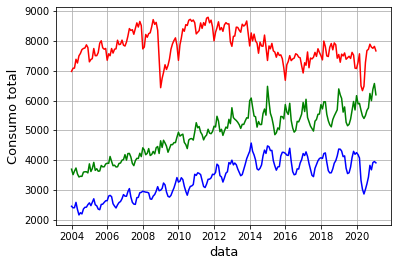

In [591]:
# Southeast consumption graph
plt.plot(originaldata.index, originaldata.ind_se, color='red')
plt.plot(originaldata.index, originaldata.com_se, color='blue')
plt.plot(originaldata.index, originaldata.res_se, color='green')

plt.xlabel('data', fontsize = 13)
plt.ylabel('Consumo total',fontsize = 13)
plt.grid()

# O consumo residencial (verde) tende a aumentar, pelo aumento populacional e democratização de bens eletrônicos
# O consumo industrial (vermelho) estagnado reflete o fechamento de diversas industrias no estado de SP
# O consumo comercial não apresenta crescimento desde 2014, mas oscila menos que a indústria

# Pelas especificidades de cada forma de consumo, é necessário fazer análises separadas, visto que cada tipo de consumo...
# ...segue uma lógica própria

In [592]:
# Dickey-Fuller Test


def dickey_fuller(column, df):
    test = adfuller(df[column][:206])
    result = {}
    result['Teste'] = test[0]
    result['p-value'] = test[1]
    result['Lags'] = test[2]
    result['N observations'] = test[3]
    result['1%'] = test[4]['1%']
    result['5%'] = test[4]['5%']
    result['10%'] = test[4]['10%']
    return(pd.Series(result))


print(dickey_fuller('ind_se', originaldata), '\n')
print(dickey_fuller('com_se', originaldata), '\n')
print(dickey_fuller('res_se', originaldata))

# Nenhum consumo segue uma tendência estacionária

Teste              -2.505833
p-value             0.114061
Lags               12.000000
N observations    193.000000
1%                 -3.464694
5%                 -2.876635
10%                -2.574816
dtype: float64 

Teste              -1.811753
p-value             0.374642
Lags               14.000000
N observations    191.000000
1%                 -3.465059
5%                 -2.876794
10%                -2.574901
dtype: float64 

Teste              -1.790436
p-value             0.385220
Lags               12.000000
N observations    193.000000
1%                 -3.464694
5%                 -2.876635
10%                -2.574816
dtype: float64


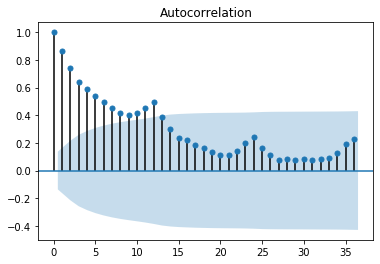

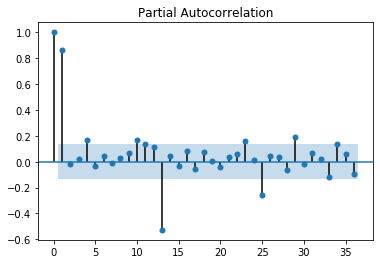

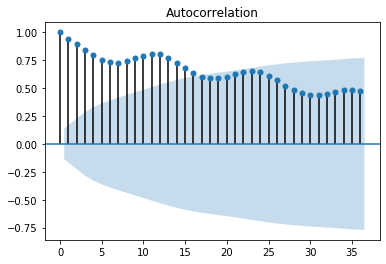

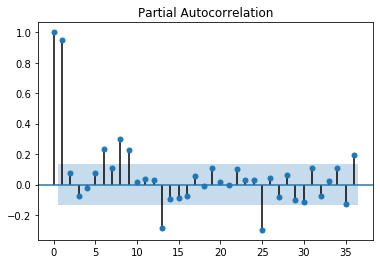

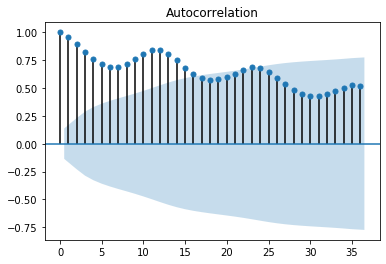

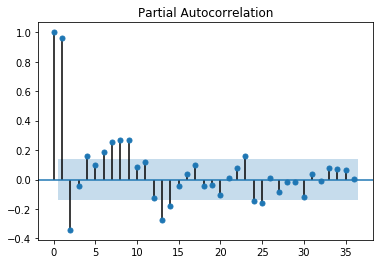

In [593]:
# Autocorrelation

def autocorrelation(col, df):
    acf = plot_acf(df[col][:206], lags = 36)
    pacf = plot_pacf(df[col][:206], lags = 36)
    
# Plot
autocorrelation('ind_se', originaldata)
autocorrelation('res_se', originaldata)
autocorrelation('com_se', originaldata)

# Há autocorrelação para vários lags, então é necessário haver um fator autorregressivo
# Existem picos, especialmente para a autocorrelação parcial em múltiplos de 13, indicando sazonalidade anual
# Também foi visto que a série não é estacionário, gerando a necessidade de diferenciação para 12 meses

[Text(0, 0.5, 'Valor'),
 Text(0.5, 0, 'Ano'),
 Text(0.5, 1.0, 'Diferenciação Residencial')]

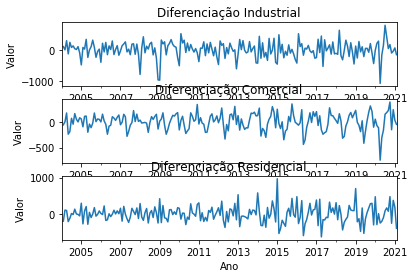

In [594]:
# Differentiation
ind_dif = originaldata['ind_se'][:206].diff()
com_dif = originaldata['com_se'][:206].diff()
res_dif = originaldata['res_se'][:206].diff()

fig, axs = plt.subplots(nrows=3)   
ind_dif.plot(ax=axs[0]).set(
    xlabel=' ',
    ylabel='Valor', 
    title='Diferenciação Industrial')
com_dif.plot(ax=axs[1]).set(
    xlabel=' ',
    ylabel='Valor', 
    title='Diferenciação Comercial')
res_dif.plot(ax=axs[2]).set(
    xlabel='Ano',
    ylabel='Valor', 
    title='Diferenciação Residencial')

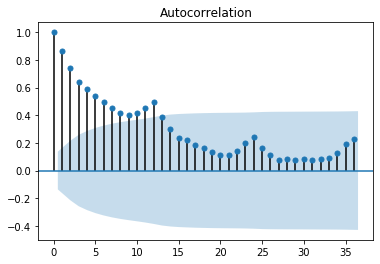

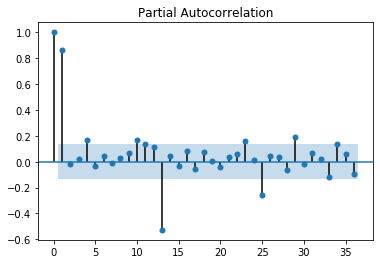

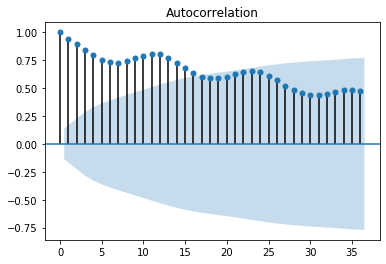

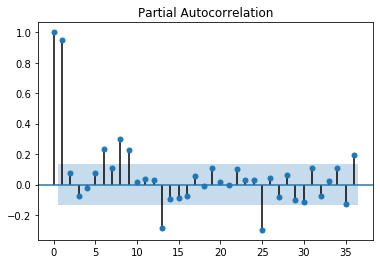

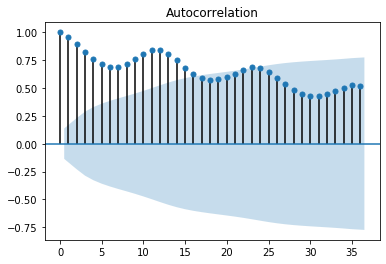

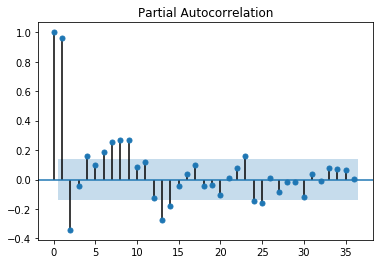

In [595]:
# Creating DataFrame of differentiation
dif = pd.DataFrame([ind_dif, com_dif, res_dif]).T[1:]

# Plot
autocorrelation('ind_se', originaldata)
autocorrelation('res_se', originaldata)
autocorrelation('com_se', originaldata)

# Há decaímento nos picos de 12 meses da autocorrelação parcial, então a diferenciação de ordem 1 é aceita

In [596]:
# Dickey-Fuller Test
print(dickey_fuller('ind_se', dif), '\n')
print(dickey_fuller('com_se', dif), '\n')
print(dickey_fuller('res_se', dif))

# Há estacionaridade (p<0.05)

Teste              -3.612303
p-value             0.005530
Lags               11.000000
N observations    193.000000
1%                 -3.464694
5%                 -2.876635
10%                -2.574816
dtype: float64 

Teste              -2.903511
p-value             0.044941
Lags               13.000000
N observations    191.000000
1%                 -3.465059
5%                 -2.876794
10%                -2.574901
dtype: float64 

Teste            -7.743227e+00
p-value           1.048372e-11
Lags              1.100000e+01
N observations    1.930000e+02
1%               -3.464694e+00
5%               -2.876635e+00
10%              -2.574816e+00
dtype: float64


In [597]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [275]:
from itertools import product

p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [562]:
# Train and Test data
data_train_ind = dif['ind_se'][0:165]
data_test_ind = dif['ind_se'][166:206]
data_train_res = dif['res_se'][0:165]
data_test_res = dif['res_se'][166:206]
data_train_com = dif['com_se'][0:165]
data_test_com = dif['com_se'][166:206]


# Esse processo pode levar algumas horas
result_df_ind = optimize_SARIMA(parameters_list, 1, 1, 12, data_train_ind)
result_df_res = optimize_SARIMA(parameters_list, 1, 1, 12, data_train_res)
result_df_com = optimize_SARIMA(parameters_list, 1, 1, 12, data_train_com)

# Resposta Questão 3:
#### abaixo estão o ranking dos 5 melhores modelos, o critério de seleção foi "menor IAC"

In [183]:
result_df_ind.head(5)

,"(p,q)x(P,Q)",AIC
0,"(2, 3, 0, 2)",2014.587473
1,"(2, 3, 0, 3)",2015.116549
2,"(2, 3, 1, 2)",2015.205897
3,"(0, 1, 0, 2)",2016.401664
4,"(0, 1, 1, 1)",2016.930083


In [184]:
result_df_res.head(5)

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 0, 1)",1986.467765
1,"(0, 2, 3, 2)",1986.477341
2,"(0, 2, 2, 2)",1986.603269
3,"(0, 3, 0, 1)",1986.634738
4,"(0, 2, 0, 1)",1987.241509


In [185]:
result_df_com.head(5)

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 0, 3)",1855.183743
1,"(1, 2, 2, 1)",1855.969644
2,"(2, 3, 0, 3)",1856.589588
3,"(3, 3, 0, 3)",1856.962446
4,"(2, 2, 0, 3)",1857.229941


# Continuação Questão 2

In [600]:
# Creating model with train + test data
best_model_ind = SARIMAX(dif['ind_se'][0:206], order=(2, 1, 3), seasonal_order=(0, 1, 2, 12)).fit(dis=-1)
best_model_res = SARIMAX(dif['res_se'][0:206], order=(1, 1, 2), seasonal_order=(0, 1, 1, 12)).fit(dis=-1)
best_model_com = SARIMAX(dif['com_se'][0:206], order=(1, 1, 2), seasonal_order=(0, 1, 3, 12)).fit(dis=-1)

print(best_model_ind.summary())
print(best_model_res.summary())
print(best_model_com.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             ind_se   No. Observations:                  205
Model:             SARIMAX(2, 1, 3)x(0, 1, 2, 12)   Log Likelihood               -1310.830
Date:                            Mon, 28 Jun 2021   AIC                           2637.661
Time:                                    00:25:00   BIC                           2663.721
Sample:                                02-01-2004   HQIC                          2648.215
                                     - 02-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7677      0.063    -28.012      0.000      -1.891      -1.644
ar.L2         -0.9998      0.026   

In [601]:
# Plot difference graph
def plot_forecast(col, model):
    col_model_name = 'Sarima_Model_' + col
    # Insert model values
    dif[col_model_name] = model.fittedvalues
    dif[col_model_name][:12+1] = np.NaN
    forecast = model.predict(start=dif.shape[0] - 40, end=dif.shape[0] + 24 )
    forecast = dif[col_model_name].append(forecast)
    
    # Plot
    plt.figure(figsize=(15, 7.5))
    plt.plot(forecast, color='r', label='previsto')
    plt.axvspan(dif.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(dif[col], label='real')
    plt.legend()
    plt.show()

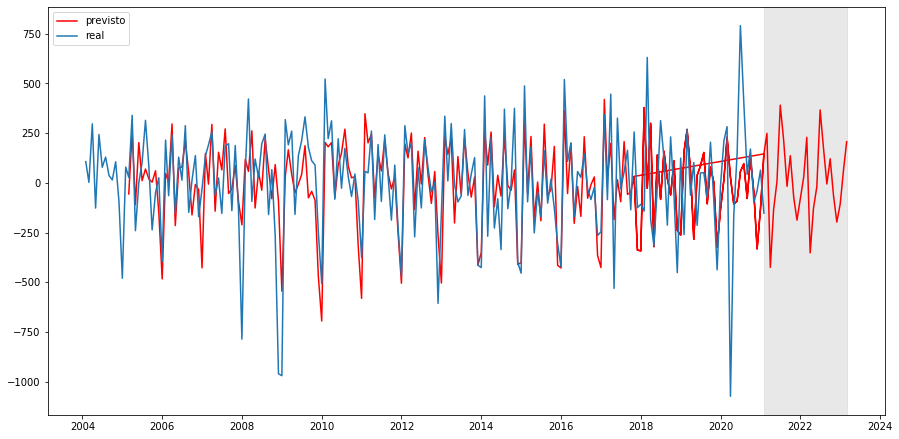

In [602]:
# Industrial plot
plot_forecast('ind_se', best_model_ind)

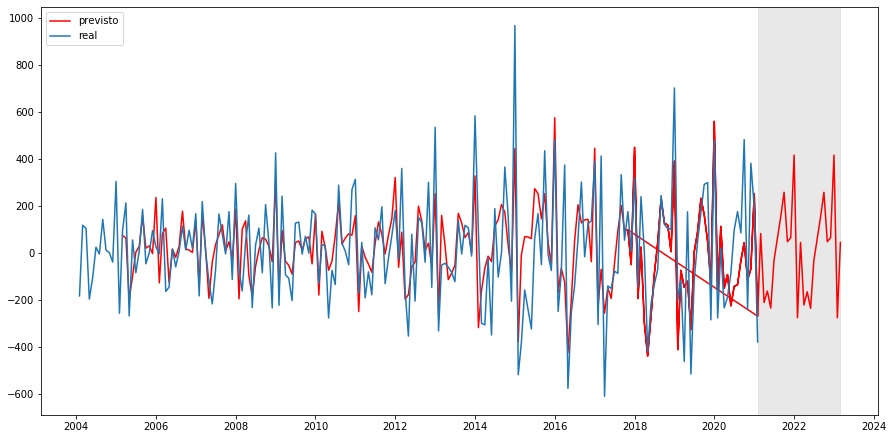

In [603]:
# Residential plot
plot_forecast('res_se', best_model_res)

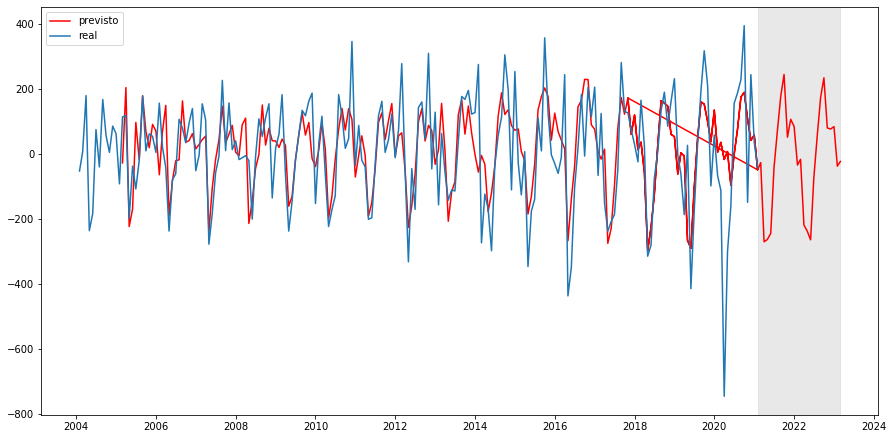

In [604]:
# Comercial plot
plot_forecast('com_se', best_model_com)

# Questão 4
#### Foi possível observar a possibilidade da previsão do consumo energético, mesmo para as 3 formas de consumo que possuem características próprias. Também observamos, na questão 1, certos padrões, como a intensificação do consumo de energia no final do ano para várias regiões e sua relação com as festas de final de ano. Os padrões não servem para todas as regiões, pelo fato do Brasil ser um país marcado por suas regionalidades que afetam vários tipos de consumo, inclusive o energético.
